# <center> ДЗ 2 (Темы: Groupby, Merge, Visualization)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Распакуйте архив "Из задания 1" в текущую папку. Считайте в переменные tr_mcc_codes, tr_types, transactions и customers_gender_train таблицы из соответствующих csv фалов в папке data из архива (см. csv_read.py). В transactions считайте только первые 1000000 строк.

In [18]:
gender_train = pd.read_csv("data/gender_train.csv")
print(gender_train.head())
transactions = pd.read_csv("data/transactions.csv", nrows=1000000)
print(transactions.head())

# считается плохо, нужно править, посмотрите на вывод head и на содержимое gender_train.csv, tr_types.csv
tr_types = pd.read_csv("data/tr_types.csv", sep=";")
print(tr_types.head())

# считается с ошибкой, тоже нужно править
tr_mcc_codes = pd.read_csv("data/tr_mcc_codes.csv", sep=";")
print(tr_mcc_codes.head())


   customer_id  gender
0     10928546       1
1     69348468       1
2     61009479       0
3     74045822       0
4     27979606       1
   customer_id tr_datetime  mcc_code  tr_type    amount term_id
0     39026145  0 10:23:26      4814     1030  -2245.92     NaN
1     39026145  1 10:19:29      6011     7010  56147.89     NaN
2     39026145  1 10:20:56      4829     2330 -56147.89     NaN
3     39026145  1 10:39:54      5499     1010  -1392.47     NaN
4     39026145  2 15:33:42      5499     1010   -920.83     NaN
   tr_type                                     tr_description
0     3200  Плата за предоставление услуг посредством моби...
1     3210  Плата за предоставление отчета по счету карты ...
2     3800  Плата за обслуживание банковской карты (за пер...
3     4000            Плата за получение наличных в Сбербанке
4     4001  Плата за получение наличных в Сбербанке (в дру...
   mcc_code                                    mcc_description
0       742                                

#### Задание 0.
Соедините transactions с всеми остальными таблицами (tr_mcc_codes, tr_types, gender_train). Причём с customers_gender_train необходимо смёрджиться с помощью left join, а с оставшимися датафреймами - через inner.
После получения результата таблицы gender_train, tr_types, tr_mcc_codes можно удалить. В результате соединения датафреймов должно получиться 999584 строки.

In [44]:
### Type your code here
merged = transactions\
    .merge(gender_train, on="customer_id", how="left")\
    .merge(tr_types, on="tr_type", how="inner")\
    .merge(tr_mcc_codes, on="mcc_code", how="inner")

print(len(merged))

999584


#### Задание 1.
1. Определите модуль разницы между средними тратами женщин и мужчин (трата - отрицательное значение amount). (*)

Выведите ответ в виде вещественного числа, округлённого до двух знаков после запятой, отделив дробную часть точкой в формате "123.45"

##### Пояснения:
(\*) Если в результате для мужчин получились значения [-1,-3,-5], а для женщин [-1,-2,-3],
то модуль разницы между средними арифметическими -3 и -2 будет равен 1.

(\**) Обратите внимание, что для вычисления модуля разности точных знаний о том,
какой класc относится к мужчинам, а какой - к женщинам, пока не требуется.

(\***) Округление не нужно производить отдельно по средним тратам женщин и мужчин, а только в самом конце, когда получите значение модуля разницы трат.

In [45]:
### Type your code here
grouped_list = list(merged.loc[merged["amount"] < 0].groupby(by="gender")["amount"].mean())
abs_dif = round(abs(grouped_list[0] - grouped_list[1]), 2)
print(abs_dif)


32718.05


#### Задание 2:
1. Создайте новый столбец - mcc_code+tr_type, сконкатенировав значения из соответствующих столбцов. (\*)
2. Оставьте только наблюдения с отрицательным значением amount. Посчитайте дисперсию по категориям получившегося столбца mcc_code+tr_type, в которых количество наблюдений >= 10.
3. Определите отношение максимальной дисперсии к минимальной.

Выведите ответ в виде вещественного числа, округлённого до ближайшего целого в формате "123456" без дробной части.

##### Пояснения:
(\*) Для конкатенации значений в столбцах можно использовать метод .astype(str) для серии и складывать соответствующие серии. Либо же применять apply к строкам датафрейма, прописывая логику преобразования и конкатенации значений внутри.

(\**) Для одновременного подсчета количества наблюдений и дисперсии по категориям можно воспользоваться функцией .agg()

In [46]:
### Type your code here
merged["mcc_code+tr_type"] = merged["mcc_code"].astype(str) + merged["tr_type"].astype(str)
second = merged.loc[merged["amount"] < 0]
result_df = second.groupby(by="mcc_code+tr_type")["amount"].agg(['count', 'var']).query("count >= 10")["var"]
result = round(result_df.max() / result_df.min())
print(result)


9170599


#### Задание 3:
1. По всем типам транзакций рассчитайте максимальную сумму прихода на карту (из строго положительных сумм по столбцу amount) отдельно для мужчин и женщин (назовите ее "max_income"). Оставьте по 5 транзакций для мужчин и для женщин, наименьших среди всех транзакций по полученным значениям "max_income". (\*)
2. Выделите среди них те, которые встречаются одновременно и у мужчин, и у женщин:
    - 1) Покупка. POS ТУ СБ РФ
    - 2) Списание после проведения претензионной работы
    - 3) Плата за получение наличных. Россия
    - 4) Перевод на карту/ с карты через АТМ (со взиманием комиссии с отправителя) по счету в овердрафте
    - 5) __Плата за получение наличных в АТМ. Россия__  ✓
    - 6) Наличные. Зарубеж. банк
    - 7) Возврат покупки. POS ТУ Россия

##### Пояснения:
(\*) Если максимальные суммы приходов по каким-то типам были равны [1,2,3,4,5,6,7,8], то 5 минимальных из них: [1,2,3,4,5]

In [54]:
### Type your code here
third = merged.loc[merged["amount"] > 0]
third.groupby(["tr_type", "gender"])["amount"].max().nsmallest(5)

tr_type  gender
4051     0.0       1122.96
2020     1.0       2245.92
4110     0.0       2245.92
         1.0       2245.92
4210     0.0       2245.92
Name: amount, dtype: float64

In [57]:
merged.loc[merged["tr_type"] == 4110]["tr_description"].unique()

array(['Плата за получение наличных в АТМ. Россия'], dtype=object)

#### Задание 4:
1. Выделите из поля tr_datetime относительный день tr_day (первое число до точного времени). (\*)
2. Отфильтруйте строки таким образом, чтобы оставить только те транзакции, у которых в соответствующий относительный день tr_day количество уникальных MCC кодов при транзакциях было больше 75 (можно воспользоваться функцией nunique())
3. Сгруппируйте полученный отфильтрованный датафрейм по MCC коду и полу, после чего, пронализировав результат, выберите верные варианты ответов ниже (\**):
    - 1) __gender == 0 - женщины, gender == 1 - мужчины__ ✓
    - 2) gender == 1 - женщины, gender == 0 - мужчины
    - 3) __Абсолютное значение медианы с типом "Флористика" (расходов/приходов) у мужчин выше той же медианы у женщин__ ✓
    - 4) Абсолютное значение медианы женских трат (расходов/приходов) на ценные бумаги выше мужских
    - 5) __Абсолютное значение медианы женских трат (расходов/приходов) в категории "Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков" ниже мужских__ ✓

##### Пояснения:
(\*) Для того, чтобы выделить всё, что стоит до первого пробела, можо использовать строковые методы для датафрейма - .str.split(), например. Либо же реализовывать логику выделения подстроки с помощью метода apply. <br>
(\**) Понять, какой класс к какому типу транзакций (мужские/женские) относится можно, если поизучать типичные для мужчин/женщин категории и сравнить средние/медианы расходов и/или приходов в них.

In [106]:
### Type your code here
merged["tr_day"] = merged["tr_datetime"].apply(lambda x: x.split()[0])
mask = merged.groupby(["tr_day"]).nunique()["mcc_code"] > 75
mask_ind = mask[mask == True].index
filtred = merged[merged["tr_day"].isin(mask_ind)]
f_grouped = filtred.groupby(["gender", "mcc_code"])["amount"]
# res_sum = f_grouped.sum().to_frame().reset_index().merge(tr_mcc_codes, on="mcc_code").sort_values(by=["amount"])

# Большие траты, без близкой пары [траты по убыванию]:
# 127 - gender: 1 - Станции тех.обслуживания
# 215 - gender: 0 - Магазины косметики
# 125 - gender: 1 - Автозапчасти и аксессуары

res_med = f_grouped.median().to_frame().reset_index().merge(tr_mcc_codes, on="mcc_code").sort_values(by=["amount"])
#res_med = res_med[res_med["mcc_description"] == "Флористика"]
#res_med = res_med[res_med["mcc_description"] == "Ценные бумаги: брокеры/дилеры"]
#res_med = res_med[res_med["mcc_description"] == "Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков"]

#res_med

,gender,mcc_code,amount,mcc_description
172,1.0,5813,-13475.49,"Бары, коктейль-бары, дискотеки, ночные клубы и..."
171,0.0,5813,-9387.93,"Бары, коктейль-бары, дискотеки, ночные клубы и..."


#### Задание 5:
1. Разбейте расходы (отрицательные значения сумм) на 5 бакетов amount_bucket равного объёма (с помощью pd.qcut), разбив все траты на категории 'Very High', 'High', 'Middle', 'Low', 'Very Low'. (\*)
2. Оставшиеся неотрицательные траты отнесите к категории 'Income'.
(воспользуйтесь функцией .cat.add_categories('Income') для того, чтобы добавить новую категорию 'Income' к категориям 'Very High', 'High', 'Middle', 'Low', 'Very Low', а затем заполните пустые значения новой категорией).
3. Из поля tr_datetime выделите час tr_hour, в который произошла транзакция, как первые 2 цифры до ":". (\**)
3. После этого постройте сводную таблицу, значениями в которой является пол gender, индексы - tr_hour, столбцы - amount_bucket.
4. Отрисуйте полученные результаты, передав их в функцию plot_pivot_table, расположенную ниже.
5. Выберите верные ответы на вопросы ниже.

#### Вопросы:
    - 1) Ночные поступления денег (01-05 часов) в более чем 85% случаев являются мужскими. ✓
    - 2) Посмотрев на долю мужчин в поступлениях средств (Income), можно сделать вывод, что количество поступлений средств женщинам в целом больше, чем мужчинам.
    - 3) Самые низкие траты в 3 часа ночи осуществляются в более 70% случаев женщинами. ✓
    - 4) Существуют особые часы в мелких тратах, когда женщины тратят намного больше мужчин (>80%)
    - 5) Посмотрев на долю мужчин в максимальных тратах средств (Very High), можно сделать вывод, что количество высоких трат в каждый возможный час мужчин больше, чем у женщин. ✓

##### Пояснения:
(\*) Обратите внимание, что в категории Very High Должны оказаться максимальные по модулю отрицательные транзакции. <br>
(\**) Например, для строки "0 10:23:26" час будет равен 10, а для строки "6 07:08:31"- 07. Можно воспользоваться функциями str.split() или str.find() и
функцией .apply(lambda x: x[])

In [203]:
def plot_pivot_table(pivot_table):
    plt.figure(figsize=(9, 11))
    sns.heatmap(pivot_table, cmap="YlGnBu", annot=True,
                fmt='.3g') #, annot_kws={"size": 14, "fontsize": 14}
    plt.xticks(fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.xlabel('Bucket', size=11)
    plt.ylabel('Hour', fontsize=11)
    plt.title('Gender analysis per bucket and hour', fontsize=20)
    plt.show()

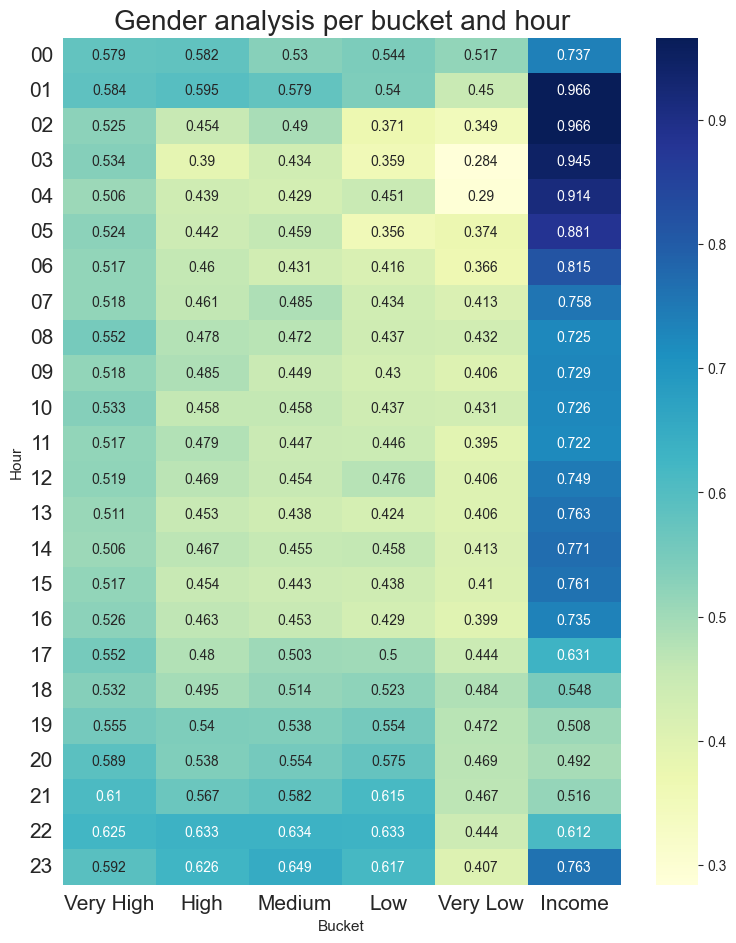

In [204]:
# Type your code here
# merged[merged["amount"] > 0]
buckets_pos = pd.qcut(merged[merged["amount"] < 0]["amount"], q=5,
        labels=[
            "Very High",
            "High",
            "Medium",
            "Low",
            "Very Low"
        ])
mrg = merged.merge(buckets_pos, left_index=True, right_index=True, how="left", suffixes=(None, "_cat"))
mrg["amount_bucket"] = mrg["amount_cat"].cat.add_categories("Income")
mrg["amount_bucket"].fillna("Income", inplace=True)
mrg["tr_hour"] = mrg["tr_datetime"].apply(lambda x: x.split()[1].split(":")[0])
submrg = mrg[["tr_hour", "gender", "amount_bucket"]]
submrg = submrg.pivot_table(index="tr_hour", columns="amount_bucket", values="gender", aggfunc="mean")
plot_pivot_table(submrg)
# # 0: women, 1: men

#### Задание 6:
1. Измените тип поля tr_day на int.
2. Выберите из transactions все MCC коды, которые встретились в выборке более чем 60000 раз.
3. Сгруппируйте отфильтрованный датафрейм по дню и MCC-коду, получая средние значения суммы amount.
4. Далее отрисуйте зависимость средних сумм (может пригодится метод unstack()) по каждому из MCC-кодов по дням.
5. Выберите верные ответы на вопросы ниже.

#### Вопросы:
    - 1) 2 из полученных MCC-кодов связаны с финансовыми институтами ✓
    - 2) 2 MCC кода, связанные со снятием наличности имеют в целом разные знаки (в одном случае почти везде - траты, в другом - пополнения) ✓
    - 3) Бакалейные магазины обладают максимальными средними тратами среди выбранных MCC-кодов
    - 4) Денежные переводы имеют как минимум 3 явных минимума средних ✓
    - 5) Категория "Звонки с использованием телефонов, считывающих магнитную ленту" имеет визуально очень большую дисперсию.

In [248]:
# Type your code here
merged["tr_day"] = merged["tr_day"].apply(pd.to_numeric)
mss_codes_60k_mask = merged.groupby("mcc_code")["mcc_code"].count() > 60000
mss_codes_indexes = mss_codes_60k_mask[mss_codes_60k_mask].index
filtred_subset = merged[merged["mcc_code"].isin(mss_codes_indexes)]
filtred_subset = filtred_subset.groupby(["tr_day", "mcc_code"])["amount"].mean()

pd.DataFrame(mss_codes_indexes).merge(tr_mcc_codes, how="left", on="mcc_code")

,mcc_code,mcc_description
0,4814,"Звонки с использованием телефонов, считывающих..."
1,4829,Денежные переводы
2,5411,"Бакалейные магазины, супермаркеты"
3,6010,Финансовые институты — снятие наличности вручную
4,6011,Финансовые институты — снятие наличности автом...


Text(0, 0.5, 'amount')

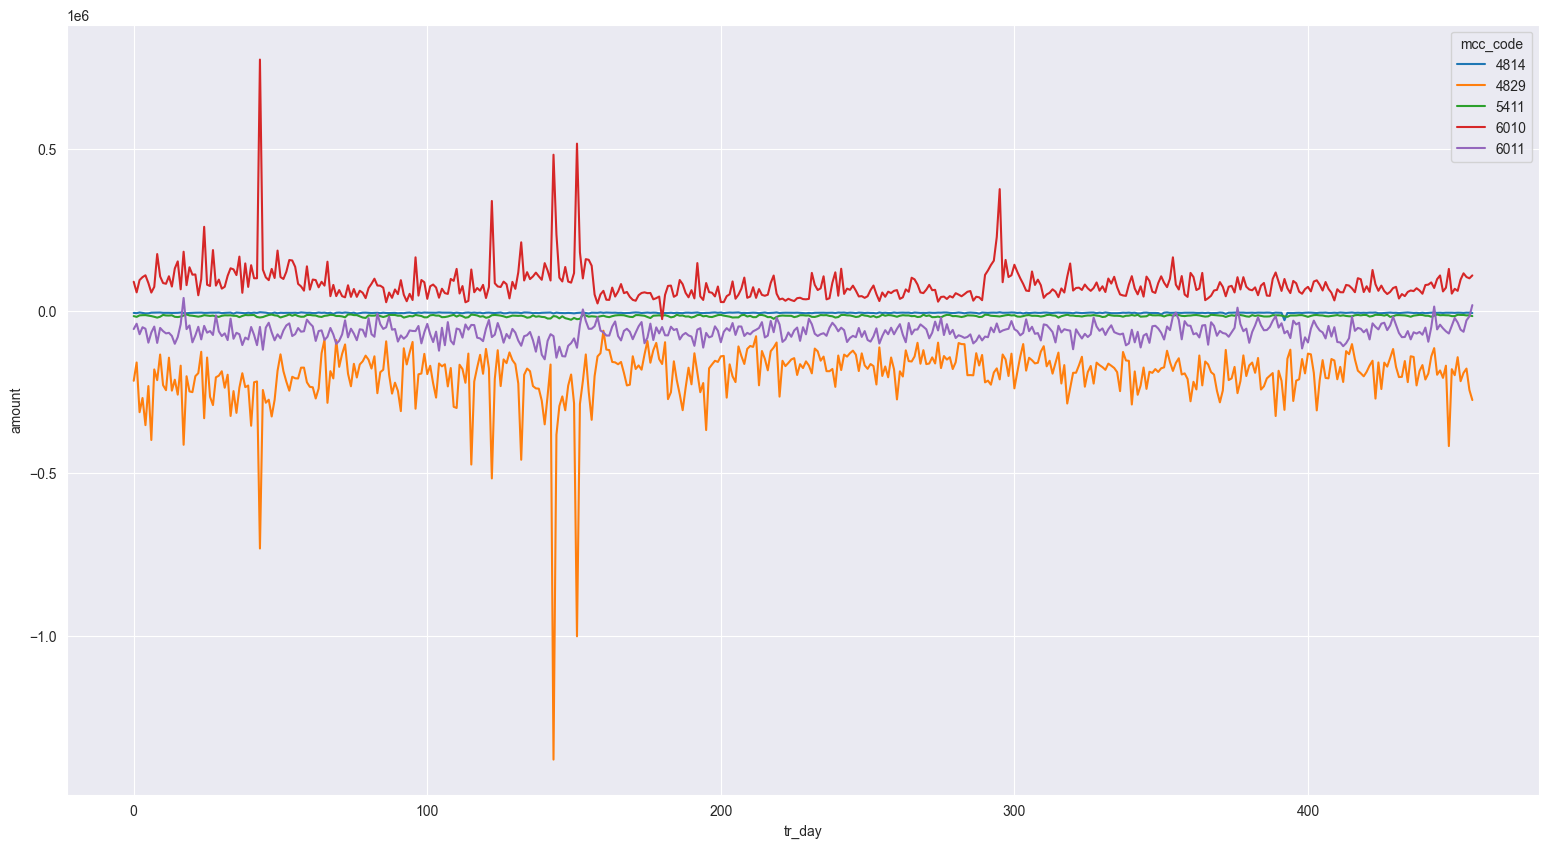

In [252]:
filtred_subset.unstack().plot(figsize=(19,10))
plt.ylabel("amount")